### ESN application: Layer-wise relevance propagation baseESN on ENSO

Inspired by [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability", we want to reproduce some of their results, but with baseESN models.

#### Data and derived sst anomaly index

SST data: https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc

Data contains **monthly mean SST** from 1854 .. 2021, in a 2° by 2° lat/lon grid:  
**lat:** 88N .. -88N (= 88S)  
**lon:** 0E .. 358E

Start from 1880. Following https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni and using the NINO3.4 box, we can diagnose the El-Nino-Southern-Oscillation Index (ENSO) from sea-surface temperature (SST). However, recipe for calculating ENSO requires some rolling mean. We omit the rolling mean here and directly take **sst anomaly index** instead.

#### Outline

- Calculate sst anomaly index
- Classify sst anomaly fields: El Nino / La Nina
- Try linear regression and baseESN for comparison (**--> see first part in notebook: ESN_exp08_LRP.ipynb**)
- Optimize baseESN (hyper-)parameters (**--> see first part in notebook: ESN_exp08_LRP.ipynb**)
- Then try layer-wise relevance propagation, with MLP and baseESN

#### Sources

Google search results for "ESN for image classification" led to some promising papers:

* [Echo State Networks-based Reservoir Computing for MNIST Handwritten Digits Recognition](https://www.researchgate.net/figure/Inputs-and-outputs-of-a-ESN-for-image-classification-with-N-i-28_fig2_309033779)
* [On the Post-hoc Explainability of Deep Echo State Networks for Time Series Forecasting, Image and Video Classification](https://arxiv.org/abs/2102.08634) from Feb 2021
* [A Reservoir Computing approach to Image Classification using Coupled Echo State and Back-Propagation Neural Networks](https://www.sacral.c.u-tokyo.ac.jp/pdf/woodward_ivcnz_2011.pdf).
* [An image classification method based on Echo State Network](https://ieeexplore.ieee.org/document/9607999) from Nov 2021 (for purchase!)

### Tech preamble

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.special import softmax, expit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, LSTM, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

import hvplot.xarray
import matplotlib.patches as patches

### Work with my own library of useful ESN functions

## If we want to have zero input and reservoir bias, b_in and b_res, respectively, use:
#from ESN_functions_v04_nobias import * 

## Or dedice to work with regular randomly initialized bias, b_in and b_res, respectively, use:
from ESN_functions_v04 import * 

### Load SST data

In [2]:
# Use, when working with relative path on local machine (or nesh)
sst_path = "../data/sst.mnmean.nc"
sst_dataset = xr.open_dataset(sst_path)
sst_dataset

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2015, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-12-06

### Calculating SST anomaly index from sst data

There are several indices used to monitor the tropical Pacific, all of which are based on SST anomalies averaged across a given region.  Usually the anomalies are computed relative to a base period of 30 years.  The Niño 3.4 index is one of the most commonly used indices to define El Niño and La Niña events.

Website https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni gives introduction to ENSO indices. Paper [Morrow et al., 2010] shows index for Niño 3.4 region (5°N–5°S, 120–170°W) in the tropical Pacific. The website references a link to an "expert guide" with more detailed information and a recipe on calculating ENSO indices:

(...) Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (here 1980-2009) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period. (...)

**Note:** We omit smoothing with rolling mean here and hence call it *sst anomaly index* instead of *ENSO index*.

In [70]:
### Compute area averaged total SST from Niño 3.4 region (5°N–5°S, 120–170°W).
# Note: Since the box of interest is close to equator (5°N-5°S) we simply average over the box area and don't take care
# care of area weighting here.
# Note: latitude comes in a grid 88, 86, .., -86, 88, slice(5,-5) is actually using (4°N-4°S) only.
# Note: longitude ranges from 0 to 358°E. Region of interest (120-170°W) translates to (190°E-240°E) here.
sst_mean = (
    sst_dataset.sst.sel(time=slice('1880-01-01', '2021-11-01'))
    .sel(lat=slice(5,-5)).sel(lon=slice(190,240))
    .mean(("lat", "lon"))
)

# Compute monthly climatology (here: 1980-2009) for area averaged total SST from Niño 3.4 region
sst_climatology = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon", "time"))
)

# Compute std dev in ime for monthly climatology (here: 1980-2009), 
# use area averaged total SST from Niño 3.4 region
sst_climatology_std = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .std("time")          
)

# Subtract climatology from area averaged total SST time series to obtain anomalies
sst_anomaly = sst_mean - sst_climatology

# ENSO index is calculated as 5 months rolling mean of sst anomaly.
# We aim to label time sclices of lat/lon grids according to their phase: "El Nino" / "La Nina".
# This requires sst_anomaly WITHOUT rolling mean!
# But still normalize sst anomaly by dividing by standard deviation of sst climatology, as done for ENSO index:
sst_anomaly_norm = sst_anomaly / sst_climatology_std

## de-trending norm. sst anomaly index using first order polynomial fit, to remove linear trend.

# Get trend parameters from polyfit
x_index = np.array(range(len(sst_anomaly_norm.values)))
trend_param = np.polyfit(x_index, sst_anomaly_norm.values, 1)
print("trend parameters: ",trend_param)

# Restore trend from obtained trend parameters
trend = x_index*trend_param[0]+trend_param[1]

# Subtract trend
sst_anomaly_norm.values = sst_anomaly_norm.values - trend

trend parameters:  [ 3.79827327e-04 -6.55894635e-01]


### Image Classification with MLP

As in [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability", try to set up simple MLP for image classification of sst anomaly fields.

In [174]:
### Prepare inputs and targets for base ESN on sst anomaly fields

# Again get raw sst fields as lat/lon grids in time, from 1880 to date:
#sst_fields = sst_dataset.sst.sel(time=slice('1880-01-01', '2021-11-01'))
sst_fields = (
    sst_dataset.sst
    .sel(time=slice('1880-01-01', '2021-11-01'))
#    .sel(lat=slice(20,-20)).sel(lon=slice(150,280))  ### Only, if we don't want to take whole worlds sst fields!
)

# Compute monthly climatology (here 1980 - 2009) for whole world
sst_climatology_world = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
#    .sel(lat=slice(20,-20)).sel(lon=slice(150,280))  ### Only, if we don't want to take whole worlds sst fields!
    .mean("time")
)


# Get sst anomaly fields:
sst_anomaly_fields = sst_fields - sst_climatology_world

# Only keep sst anomaly fields connected either El Nino or La Nina event.
sst_anomaly_fields_NinoNina = sst_anomaly_fields[(sst_anomaly_norm.values > 0.5) | (sst_anomaly_norm.values < -0.5)]

# Extract sst anomaly fields' values as iputs:
inputs = np.copy(sst_anomaly_fields_NinoNina.values)

# Replace nan values by ZERO
inputs[np.isnan(inputs)] = 0

# It might be a problem to first set nan values to zero, then apply min/max scaling.
# After scaling former nan values are non-zero!
# On the other hand we cannot get necessary min/max values as long as we have nan values.
# Solution: Replace nan by zero. Apply min/max scaling. Then again set former nan values to zero.

# Check how many nan values we have:
temp_isnan = np.isnan(sst_anomaly_fields_NinoNina.values)
temp_isnan_rel = sum(sum(sum(temp_isnan))) / (temp_isnan.shape[0] * temp_isnan.shape[1] * temp_isnan.shape[2])
print("rel. amount of nan values in inputs BEFORE modification: ", np.round(temp_isnan_rel,2))

# Get targets from sst anomaly index:
targets = sst_anomaly_norm.values[(sst_anomaly_norm.values > 0.5) | (sst_anomaly_norm.values < -0.5)]

# Also convert targets to binary targets (1 / 0) for El Nino / La Nina.
targets_bin = (targets > 0.5).astype(int)

# Reshape targets to (samples, 1):
targets = targets.reshape((len(targets), 1))
targets_bin = targets_bin.reshape((len(targets_bin), 1))

# Create one-hot targets for two unit output (El Nino / La Nina):
targets_onehot = np.concatenate([(targets_bin==1).astype(int),(targets_bin==0).astype(int)], axis=1)

## Split inputs and targets into train and validation data according to train_val_split.

# Set rel. amount of samples used for training:
train_val_split = 0.8

# Get number of train samples:
n_train = int(len(inputs) * train_val_split)

## Scale inputs to [-1,1] according to min/max obtained from only train inputs.
# Remenber min/max used for scaling.
train_min = np.min(inputs[:n_train])
train_max = np.max(inputs[:n_train])
# Scale to either [-1,1] or [0,1]
inputs = 2 * (inputs - train_min) / (train_max - train_min) - 1

## Alternatively scale inputs to [0,1]
#inputs = (inputs - train_min) / (train_max - train_min)


# Again set former nan values to zero after scaling:
inputs = inputs * np.invert(temp_isnan)

# Flatten inputs:
inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1]*inputs.shape[2]))

# Split inputs and targets:
train_input = inputs[:n_train]
val_input = inputs[n_train:]
train_target = targets[:n_train]
val_target = targets[n_train:]
train_target_bin = targets_bin[:n_train]
val_target_bin = targets_bin[n_train:]
train_target_onehot = targets_onehot[:n_train]
val_target_onehot = targets_onehot[n_train:]

## Additionally scale targets to [-1,1] according to min/max obtained from only train targets.
# Remenber min/max used for scaling.
train_target_min = np.min(train_target)
train_target_max = np.max(train_target)
# Scale
train_target_scaled = 2 * (train_target - train_target_min) / (train_target_max - train_target_min) - 1
val_target_scaled = 2 * (val_target - train_target_min) / (train_target_max - train_target_min) - 1

# Dimensionality check:
print("\ninputs shape (all input samples): ", inputs.shape)
print("train_input shape: ", train_input.shape)
print("val_input shape: ", val_input.shape)
print("\ntargets shape (all targets): ", targets.shape)
print("train_target shape: ", train_target.shape)
print("val_target shape: ", val_target.shape)
print("train_target_onehot shape: ", train_target_onehot.shape)
print("val_target_onehot shape: ", val_target_onehot.shape)
print("\ntrain_inputs min: ", train_min)
print("train_inputs max: ", train_max)
print("\nscaled train_inputs min: ", np.min(train_input))
print("scaled train_inputs max: ", np.max(train_input))
print("scaled val_inputs min: ", np.min(val_input))
print("scaled val_inputs max: ", np.max(val_input))
print("\nun-scaled train_target min: ", np.min(train_target))
print("un-scaled train_target max: ", np.max(train_target))
print("un-scaled val_target min: ", np.min(val_target))
print("un-scaled val_target max: ", np.max(val_target))
print("\nscaled train_target min: ", np.min(train_target_scaled))
print("scaled train_target max: ", np.max(train_target_scaled))
print("scaled val_target min: ", np.min(val_target_scaled))
print("scaled val_target max: ", np.max(val_target_scaled))

rel. amount of nan values in inputs BEFORE modification:  0.31

inputs shape (all input samples):  (1083, 16020)
train_input shape:  (866, 16020)
val_input shape:  (217, 16020)

targets shape (all targets):  (1083, 1)
train_target shape:  (866, 1)
val_target shape:  (217, 1)
train_target_onehot shape:  (866, 2)
val_target_onehot shape:  (217, 2)

train_inputs min:  -14.661811
train_inputs max:  16.449982

scaled train_inputs min:  -1.0
scaled train_inputs max:  1.0
scaled val_inputs min:  -0.9002365
scaled val_inputs max:  1.1000342

un-scaled train_target min:  -2.794030168975706
un-scaled train_target max:  2.385727969085769
un-scaled val_target min:  -2.189945398540901
un-scaled val_target max:  2.464253690875403

scaled train_target min:  -1.0
scaled train_target max:  1.0
scaled val_target min:  -0.7667517461883331
scaled val_target max:  1.0303202271984935


Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 16020)]           0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 128168    
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 18        
Total params: 128,258
Trainable params: 128,258
Non-trainable params: 0
_________________________________________________________________


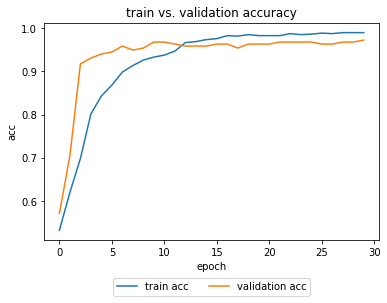

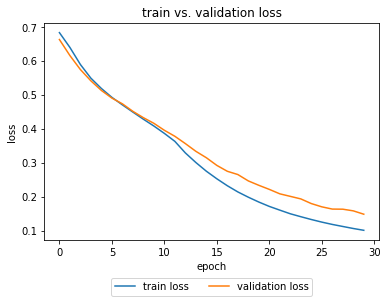

In [175]:
### Set up MLP

# Set up layers:
inputs = Input(shape=(train_input.shape[1]))
hidden_1 = Dense(8, activation='relu')(inputs)
hidden_2 = Dense(8, activation='relu')(hidden_1)
output = Dense(2, activation='sigmoid')(hidden_2)

# Define and compile model :
model = Model(inputs, output, name='MLP')
opt = SGD(lr=0.001)#Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
model.summary()

# plot model
plot_model(model, show_shapes=True, show_layer_names=True)

# train model
epc = 30
history = model.fit(train_input, train_target_onehot, epochs=epc, verbose=0,
                    batch_size=10, validation_data=(val_input, val_target_onehot))

train_acc = history.history['acc']
val_acc = history.history['val_acc']

# evaluation
plt.plot(train_acc, label='train acc'), 
plt.plot(val_acc, label='validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# evaluation
plt.plot(history.history['loss'], label='train loss'), 
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('train vs. validation loss')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Discussion on Image Classification and LRP with MLP

Closely sticked to methodology introduced by [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability".

Set up identical MLP, works fine for **image classification**, reach some accuracy close to 100% on both, train and validation data. Worked with whole world's sst anomaly fields as input and generated one-hot targets on normalized sst anomaly index.

### Next: LRP with trained MLP

Now try **LRP** for randomly picked input sample (El Nino event). Considered only *positive* relevance for *first* output unit - the one that refers to El Nino event. Then try various approaches of backpropagating relevance until reaching input layer:

1) Use only *squared weights* for propagation rule (except for OUTPUT connecting HID_2). Don't care about activations. But since we work with *relu* activation in hidden layers, only have non-zero post-potentials.

2) Now multiply post-potentials with weights to get pre-potentials, but only take positive contributions of pre-potentials into account.

3) In addition to 2) only take positive contributions of pre-potentials into account also for OUPUT layer connecting second hidden layer and ignore output bias. 

4) Take both, positive AND negative contributions of pre-potential into account, also for OUPUT layer connecting second hidden layer and ignore output bias.

5) Use only positive weights for propagation rule, but not squared, as in 1).

#### Results

Find only 1) and 5) to provide useful relevance maps, as expected and seen in Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002).

We then have the input weights connecting all input units x_i to all units x_j of first hidden layer. In this case it helps to look for non-zero (positive, since using relu activation in first hidden layer) post-potentials of first hidden layer. Then looked at heatmaps for weights connecting input units to each hidden unit x_j, separately: Find same structure as in relevance map in heatmap of trained weights, but only for units x_j with non-zero (positive) post-potential, as also seen in linear regression.

Sample dimensions and prediction:
raw sample shape (1, features):  (1, 16020)
number of input features in_feat:  16020
model prediction on sample:  0.343

Model weights and biases, Dimensions:
input weights W_in (input features, hidden units):  (16020, 8)
input biases b_in (hidden units):  (8,)
hidden weights W_hidden (hidden units, hidden units):  (8, 8)
hidden biases b_hidden (hidden units):  (8,)
output weights W_out (hidden units, output units):  (8, 2)
output biases b_out (output units):  (2,)

Tensor shapes:
input tensor U (input features):  (16020,)
first hidden layer output (hidden units):   (8,)
second hidden layer output (hidden units):  (8,)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1449/2509023531.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


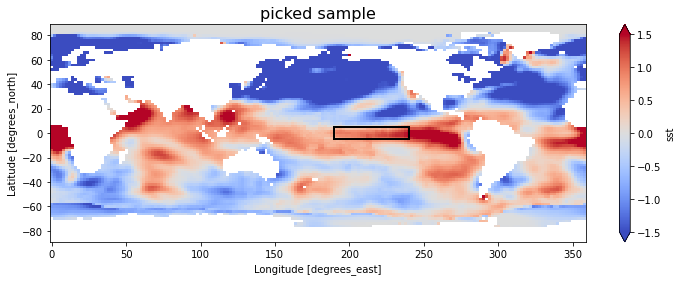

In [176]:
### Pick out ONE El Nino sample to be analysed:
sample_id = 6
sample = train_input[sample_id:sample_id+1,:]

# Plot sample input
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_fields_NinoNina[sample_id].name = 'sst anomaly deg Celsius'
sst_anomaly_fields_NinoNina[sample_id].plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('picked sample', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Extract number of input features:
in_feat = sample.shape[1]

# Have trained model as pre-requisite. Get prediction on picked sample.
# Here only the first output unit, since we picked El Nino sample.
pred = model.predict(sample)[0,0]

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, features): ", sample.shape)
print("number of input features in_feat: ", in_feat)
print("model prediction on sample: ", np.round(pred,3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_hidden = model_weights[2]
b_hidden = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, hidden units): ", W_in.shape)
print("input biases b_in (hidden units): ", b_in.shape)
print("hidden weights W_hidden (hidden units, hidden units): ", W_hidden.shape)
print("hidden biases b_hidden (hidden units): ", b_hidden.shape)
print("output weights W_out (hidden units, output units): ", W_out.shape)
print("output biases b_out (output units): ", b_out.shape)

## Get outputs from first and second hidden layer, X_1 and X_2, respectively:

# Define shortened models:
model_X1 = Model(inputs, hidden_1, name='model_X1')
model_X2 = Model(inputs, hidden_2, name='model_X2')

# Get outputs on selected sample (forward-pass) from trained short models:
X_1 = model_X1.predict(sample)[0]
X_2 = model_X2.predict(sample)[0]

# Get inputs U from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:]

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (input features): ", U.shape)
print("first hidden layer output (hidden units):  ", X_1.shape)
print("second hidden layer output (hidden units): ", X_2.shape)

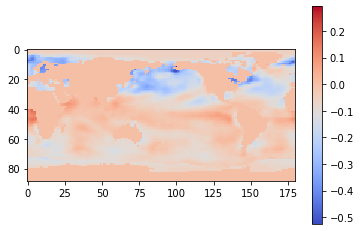

In [177]:
# Picked sample as heatmap, to see the effect of scaling input values:
plt.imshow(np.reshape(sample, (sst_fields.shape[1], sst_fields.shape[2])), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

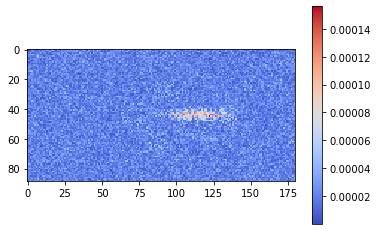

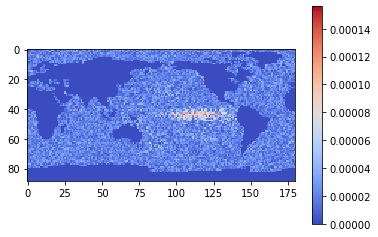

sum of relevance R_i:  0.343
sum of relevance R_j:  0.343
sum of relevance R_k:  0.343


In [180]:
### LRP on MLP: First attempt, use only squared weights for propagation rule (except for OUTPUT connecting HID_2).


## Start with connection of second HIDDEN layer (HID_2) to OUTPUT layer. Only get relevance for first output unit here.

# Get pre-activations z_io for hidden units x_i of HID_2 connecting to first OUTPUT unit x_o.
# Note: Only consider positive weights here!
z_io = np.multiply(X_2,(W_out[:,0]>0)*W_out[:,0])

# Combine pre-activations z_io to get z_o. Note: Only consider bias if positive!
z_o = sum(z_io) + (b_out[0]>0) * b_out[0] # Use b_out as scalar here!

## Quick plausibility check: sigmoid(z_o) must equal predicted value for picked sample.
# Note: Only works, if we consider ALL weights and bias!
#print("z_o: ", np.round(expit(z_o),3))
#print("prediction: ", np.round(pred,3))

# Get messages R_io for connections between OUTPUT with HID_2
R_io = z_io / (z_o - (b_out[0]>0) * b_out[0]) * pred

# Get relevances R_i for hidden units x_i of HID_2.
# Note: No summation necessary for layer HID_2, since only connected to first OUTPUT unit x_o.
R_i = np.copy(R_io)

## Continue with connection of first HIDDEN layer (HID_1) to second HIDDEN layer (HID_2).

# Get messages R_ji for connections HID_1 and HID_2
R_ji = W_hidden**2

# Or: Get directly to relevances R_j for first HIDDEN layer units x_j
R_j = np.sum((W_hidden**2) / np.sum(W_hidden**2, axis=0) * R_i, axis=1)

## And then take care about connection of INPUT layer to first HIDDEN layer (HID_1).

# Or: Get directly to relevances R_k for INPUT layer units x_k
R_k = np.sum((W_in**2) / np.sum(W_in**2, axis=0) * R_j, axis=1)

# Reshape to lat/lon grid:
R_k_2D = np.reshape(R_k, (sst_fields.shape[1], sst_fields.shape[2]))

# Set relevance to zero for gridpoints that originally had nan input, to show continents' contours:
R_k_2D_nan = np.invert(temp_isnan[sample_id]) * R_k_2D

# Relevance heatmap
plt.imshow(R_k_2D, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

# Relevance heatmap with continents' contours
plt.imshow(R_k_2D_nan, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

# Plausibility check, whether Layer relevance is conserved:
print("sum of relevance R_i: ", np.round(sum(R_i), 3))
print("sum of relevance R_j: ", np.round(sum(R_j), 3))
print("sum of relevance R_k: ", np.round(sum(R_k), 3))

In [148]:
R_i

array([-0.        ,  0.05083331, -0.        , -0.        ,  0.00751812,
       -0.        ,  0.87893456, -0.        ], dtype=float32)

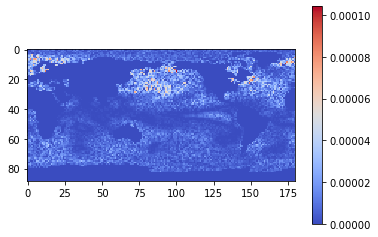

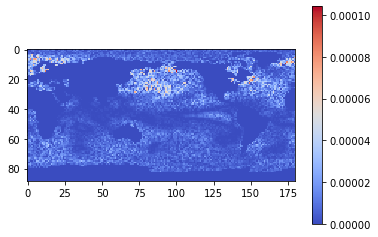

sum of relevance R_i:  0.343
sum of relevance R_j:  0.097
sum of relevance R_k:  0.096


In [189]:
### LRP on MLP: Second attempt, only take positive contributions of pre-potential into account (except for OUTPUT connecting HID_2).


## Start with connection of second HIDDEN layer (HID_2) to OUTPUT layer. Only get relevance for first output unit here.

# Get pre-activations z_io for hidden units x_i of HID_2 connecting to first OUTPUT unit x_o.
# Note: Only consider positive weights here!
z_io = np.multiply(X_2,(W_out[:,0]>0)*W_out[:,0])

# Combine pre-activations z_io to get z_o. Note: Only consider bias if positive!
z_o = sum(z_io) + (b_out[0]>0) * b_out[0] # Use b_out as scalar here!

## Quick plausibility check: sigmoid(z_o) must equal predicted value for picked sample.
# Note: Only works, if we consider ALL weights and bias!
#print("z_o: ", np.round(expit(z_o),3))
#print("prediction: ", np.round(pred,3))

# Get messages R_io for connections between OUTPUT with HID_2
R_io = z_io / (z_o - (b_out[0]>0) * b_out[0]) * pred

# Get relevances R_i for hidden units x_i of HID_2.
# Note: No summation necessary for layer HID_2, since only connected to first OUTPUT unit x_o.
R_i = np.copy(R_io)

## Continue with connection of first HIDDEN layer (HID_1) to second HIDDEN layer (HID_2).

# Get relevance R_j for 8 units x_j of HID_1 connecting to x_i units of HID_2.
# Note: Need stabilizer (epsilon=0.01) to avoid division by zero.
R_j = np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)) /
             (np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)), axis=0)+0.01)
             * R_i, axis=1)    

## And then take care about connection of INPUT layer to first HIDDEN layer (HID_1).

# Or: Get directly to relevances R_k for INPUT layer units x_k
R_k = np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))) /
             (np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))), axis=0)+0.01)
             * R_j, axis=1)    

# Reshape to lat/lon grid:
R_k_2D = np.reshape(R_k, (sst_fields.shape[1], sst_fields.shape[2]))

# Set relevance to zero for gridpoints that originally had nan input, to show continents' contours:
R_k_2D_nan = np.invert(temp_isnan[sample_id]) * R_k_2D

# Relevance heatmap
plt.imshow(R_k_2D, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

# Relevance heatmap with continents' contours
plt.imshow(R_k_2D_nan, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

# Plausibility check, whether Layer relevance is conserved:
print("sum of relevance R_i: ", np.round(sum(R_i), 3))
print("sum of relevance R_j: ", np.round(sum(R_j), 3))
print("sum of relevance R_k: ", np.round(sum(R_k), 3))

In [150]:
R_i

array([-0.        ,  0.05083331, -0.        , -0.        ,  0.00751812,
       -0.        ,  0.87893456, -0.        ], dtype=float32)

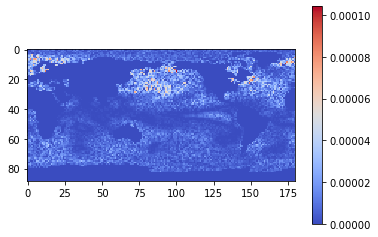

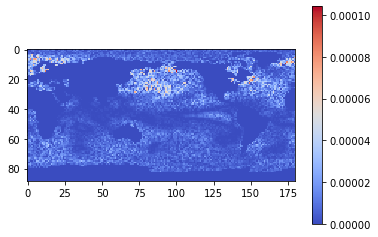

sum of relevance R_i:  0.343
sum of relevance R_j:  0.097
sum of relevance R_k:  0.096


In [188]:
### LRP on MLP: Third attempt, only take positive contributions of pre-potential into account.
###             Also for OUPUT layer connecting HID_2, ignore b_out.                

## Start with connection of second HIDDEN layer (HID_2) to OUTPUT layer. Only get relevance for first output unit here.

# Get relevances R_i for hidden units x_i of HID_2.
R_i = (np.multiply(X_2, W_out[:,0])>0) * np.multiply(X_2, W_out[:,0]) / sum((np.multiply(X_2, W_out[:,0])>0) * np.multiply(X_2, W_out[:,0])) * pred

## Continue with connection of first HIDDEN layer (HID_1) to second HIDDEN layer (HID_2).

# Get relevance R_j for 8 units x_j of HID_1 connecting to x_i units of HID_2.
# Note: Need stabilizer (epsilon=0.01) to avoid division by zero.
R_j = np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)) /
             (np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)), axis=0)+0.01)
             * R_i, axis=1)    

## And then take care about connection of INPUT layer to first HIDDEN layer (HID_1).

# Or: Get directly to relevances R_k for INPUT layer units x_k
R_k = np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))) /
             (np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))), axis=0)+0.01)
             * R_j, axis=1)    

# Reshape to lat/lon grid:
R_k_2D = np.reshape(R_k, (sst_fields.shape[1], sst_fields.shape[2]))

# Set relevance to zero for gridpoints that originally had nan input, to show continents' contours:
R_k_2D_nan = np.invert(temp_isnan[sample_id]) * R_k_2D

# Relevance heatmap
plt.imshow(R_k_2D, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

# Relevance heatmap with continents' contours
plt.imshow(R_k_2D_nan, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

# Plausibility check, whether Layer relevance is conserved:
print("sum of relevance R_i: ", np.round(sum(R_i), 3))
print("sum of relevance R_j: ", np.round(sum(R_j), 3))
print("sum of relevance R_k: ", np.round(sum(R_k), 3))

In [152]:
R_i

array([-0.        ,  0.05083331, -0.        , -0.        ,  0.00751812,
       -0.        ,  0.87893456, -0.        ], dtype=float32)

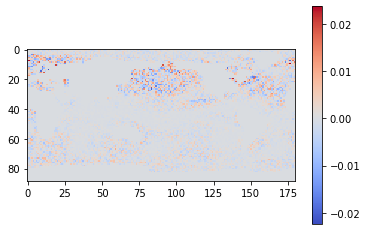

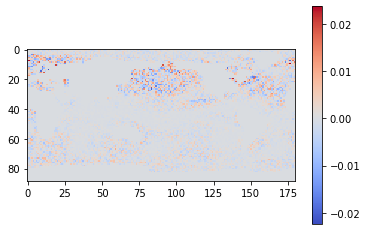

sum of relevance R_i:  0.343
sum of relevance R_j:  1.475
sum of relevance R_k:  1.466


In [187]:
### LRP on MLP: Fourth attempt, take both, positive AND negative contributions of pre-potential into account.
###             Also for OUPUT layer connecting HID_2, ignore b_out.                

## Start with connection of second HIDDEN layer (HID_2) to OUTPUT layer. Only get relevance for first output unit here.

# Get relevances R_i for hidden units x_i of HID_2.
R_i = np.multiply(X_2, W_out[:,0]) / sum(np.multiply(X_2, W_out[:,0])) * pred

## Continue with connection of first HIDDEN layer (HID_1) to second HIDDEN layer (HID_2).

# Get relevance R_j for 8 units x_j of HID_1 connecting to x_i units of HID_2.
# Note: Need stabilizer (epsilon=0.01) to avoid division by zero.
R_j = np.sum(((X_1 * W_hidden)) /
             (np.sum(X_1 * W_hidden, axis=0)+0.01)
             * R_i, axis=1)    

## And then take care about connection of INPUT layer to first HIDDEN layer (HID_1).

# Or: Get directly to relevances R_k for INPUT layer units x_k
R_k = np.sum((np.multiply(np.reshape(U, (in_feat,1)),W_in)) /
             (np.sum((np.multiply(np.reshape(U, (in_feat,1)),W_in)), axis=0)+0.01)
             * R_j, axis=1)    

# Reshape to lat/lon grid:
R_k_2D = np.reshape(R_k, (sst_fields.shape[1], sst_fields.shape[2]))

# Set relevance to zero for gridpoints that originally had nan input, to show continents' contours:
R_k_2D_nan = np.invert(temp_isnan[sample_id]) * R_k_2D

# Relevance heatmap
plt.imshow(R_k_2D, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

# Relevance heatmap with continents' contours
plt.imshow(R_k_2D_nan, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

# Plausibility check, whether Layer relevance is conserved:
print("sum of relevance R_i: ", np.round(sum(R_i), 3))
print("sum of relevance R_j: ", np.round(sum(R_j), 3))
print("sum of relevance R_k: ", np.round(sum(R_k), 3))

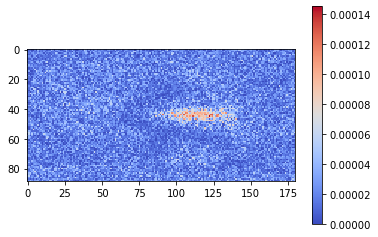

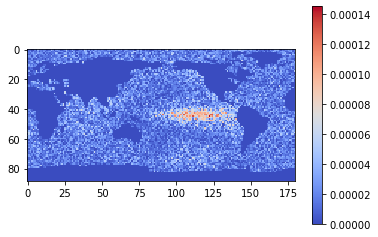

sum of relevance R_i:  0.343
sum of relevance R_j:  0.343
sum of relevance R_k:  0.343


In [186]:
### LRP on MLP: Fifth attempt, use only positive weights for propagation rule, but not squared!


## Start with connection of second HIDDEN layer (HID_2) to OUTPUT layer. Only get relevance for first output unit here.

# Get pre-activations z_io for hidden units x_i of HID_2 connecting to first OUTPUT unit x_o.
# Note: Only consider positive weights here!
z_io = np.multiply(X_2,(W_out[:,0]>0)*W_out[:,0])

# Combine pre-activations z_io to get z_o. Note: Only consider bias if positive!
z_o = sum(z_io) + (b_out[0]>0) * b_out[0] # Use b_out as scalar here!

## Quick plausibility check: sigmoid(z_o) must equal predicted value for picked sample.
# Note: Only works, if we consider ALL weights and bias!
#print("z_o: ", np.round(expit(z_o),3))
#print("prediction: ", np.round(pred,3))

# Get messages R_io for connections between OUTPUT with HID_2
R_io = z_io / (z_o - (b_out[0]>0) * b_out[0]) * pred

# Get relevances R_i for hidden units x_i of HID_2.
# Note: No summation necessary for layer HID_2, since only connected to first OUTPUT unit x_o.
R_i = np.copy(R_io)

## Continue with connection of first HIDDEN layer (HID_1) to second HIDDEN layer (HID_2).

# Get messages R_ji for connections HID_1 and HID_2
R_ji = W_hidden**2

# Or: Get directly to relevances R_j for first HIDDEN layer units x_j
R_j = np.sum((W_hidden>0) * W_hidden / np.sum((W_hidden>0) * W_hidden, axis=0) * R_i, axis=1)

## And then take care about connection of INPUT layer to first HIDDEN layer (HID_1).

# Or: Get directly to relevances R_k for INPUT layer units x_k
R_k = np.sum((W_in>0) * W_in / np.sum((W_in>0) * W_in, axis=0) * R_j, axis=1)

# Reshape to lat/lon grid:
R_k_2D = np.reshape(R_k, (sst_fields.shape[1], sst_fields.shape[2]))

# Set relevance to zero for gridpoints that originally had nan input, to show continents' contours:
R_k_2D_nan = np.invert(temp_isnan[sample_id]) * R_k_2D

# Relevance heatmap
plt.imshow(R_k_2D, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

# Relevance heatmap with continents' contours
plt.imshow(R_k_2D_nan, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

# Plausibility check, whether Layer relevance is conserved:
print("sum of relevance R_i: ", np.round(sum(R_i), 3))
print("sum of relevance R_j: ", np.round(sum(R_j), 3))
print("sum of relevance R_k: ", np.round(sum(R_k), 3))

In [185]:
X_1

array([2.4983764 , 0.        , 0.267309  , 1.9585592 , 0.50866544,
       1.4388995 , 0.        , 2.0013812 ], dtype=float32)

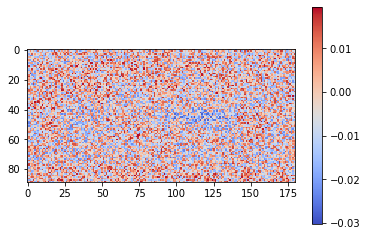

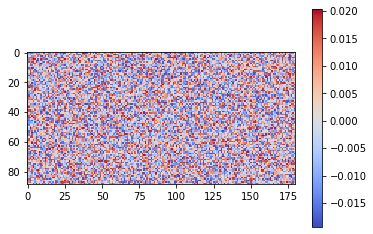

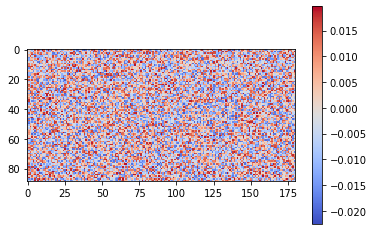

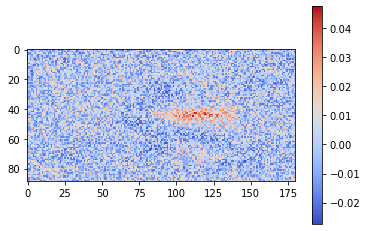

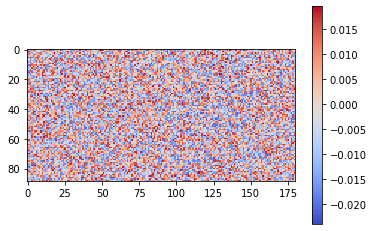

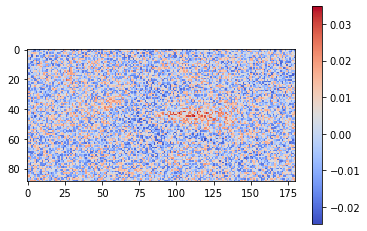

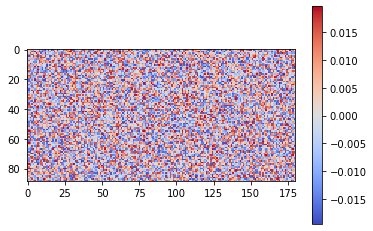

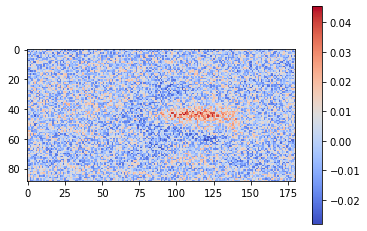

In [184]:
# Plot trained input weights W_in as heatmap
for i in range(W_in.shape[1]):
    
    # Plot weights from input units to i-th unit of first hidden layer
    plt.imshow(np.reshape(W_in[:,i], (sst_fields.shape[1], sst_fields.shape[2])), cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.show()

### Discussion on LRP with MLP

Closely sticked to methodology introduced by [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability".

Find two approaches to provide useful (as expected!) relevance maps:

1) Use only *squared weights* for propagation rule (except for OUTPUT connecting HID_2). Don't care about activations. But since we work with *relu* activation in hidden layers, only have non-zero post-potentials.

5) Use only positive weights for propagation rule, but not squared, as in 1).

**Note:** Interestingly reducing input samples' area to some **extended Pacific region** does not help for LRP: Instead of heaving highlighted "blob" of high relevance in Nino3.4 box (as expected), find only pixels in relevance map. Although MLP succeeds to classify samples to events, that's at least weird.

### Image Classification with baseESN


#### (Hyper-)parameter choice

In the first part of this experiment (**--> ESN_exp08_LRP.ipynb**) we found (slightly) modified optimal parameters four our baseESN model:

* n_res = 300
* W_in_lim = 0.1
* leak_rate = 0.1
* spec_radius = 0.8
* sparsity = 0.2

Using these parameters on detrended sst anomaly fields - scaled to [-1,1] as inputs and unscaled continuous normalized sst anomaly index as target, together with **tanh** activation we can get models with accuracy 100% on La Nina and 94% on El Nino, for both, train and validation samples. That's sufficient, stick to that set up. Multiplication with $\alpha$ is omitted in calculating first timestes's reservoir states (*leak_rate_first_step_YN = False*).

In [49]:
### Prepare inputs and targets for base ESN on sst anomaly fields

# Again get raw sst fields as lat/lon grids in time, from 1880 to date:
#sst_fields = sst_dataset.sst.sel(time=slice('1880-01-01', '2021-11-01'))
sst_fields = (
    sst_dataset.sst
    .sel(time=slice('1880-01-01', '2021-11-01'))
)

sst_climatology_world = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))  
    .mean("time")
)

# Get sst anomaly fields:
sst_anomaly_fields = sst_fields - sst_climatology_world

# Only keep sst anomaly fields connected either El Nino or La Nina event.
sst_anomaly_fields_NinoNina = sst_anomaly_fields[(sst_anomaly_norm.values > 0.5) | (sst_anomaly_norm.values < -0.5)]

# Extract sst anomaly fields' values as iputs:
inputs = np.copy(sst_anomaly_fields_NinoNina.values)

# Replace nan values by ZERO
inputs[np.isnan(inputs)] = 0

# It might be a problem to first set nan values to zero, then apply min/max scaling.
# After scaling former nan values are non-zero!
# On the other hand we cannot get necessary min/max values as long as we have nan values.
# Solution: Replace nan by zero. Apply min/max scaling. Then again set former nan values to zero.

# Check how many nan values we have:
temp_isnan = np.isnan(sst_anomaly_fields_NinoNina.values)
temp_isnan_rel = sum(sum(sum(temp_isnan))) / (temp_isnan.shape[0] * temp_isnan.shape[1] * temp_isnan.shape[2])
print("rel. amount of nan values in inputs BEFORE modification: ", np.round(temp_isnan_rel,2))

# Get targets from sst anomaly index:
targets = sst_anomaly_norm.values[(sst_anomaly_norm.values > 0.5) | (sst_anomaly_norm.values < -0.5)]

# Also convert targets to binary targets (1 / 0) for El Nino / La Nina.
targets_bin = (targets > 0.5).astype(int)

# Reshape targets to (samples, 1):
targets = targets.reshape((len(targets), 1))
targets_bin = targets_bin.reshape((len(targets_bin), 1))

## Split inputs and targets into train and validation data according to train_val_split.

# Set rel. amount of samples used for training:
train_val_split = 0.8

# Get number of train samples:
n_train = int(len(inputs) * train_val_split)

## Scale inputs to [-1,1] according to min/max obtained from only train inputs.
# Remenber min/max used for scaling.
train_min = np.min(inputs[:n_train])
train_max = np.max(inputs[:n_train])
# Scale
inputs = 2 * (inputs - train_min) / (train_max - train_min) - 1

## Alternatively scale inputs to [0,1]
#inputs = (inputs - train_min) / (train_max - train_min)

# Again set former nan values to zero after scaling:
inputs = inputs * np.invert(temp_isnan)

# Split inputs and targets:
train_input = inputs[:n_train]
val_input = inputs[n_train:]
train_target = targets[:n_train]
val_target = targets[n_train:]
train_target_bin = targets_bin[:n_train]
val_target_bin = targets_bin[n_train:]

## Additionally scale targets to [-1,1] according to min/max obtained from only train targets.
# Remenber min/max used for scaling.
train_target_min = np.min(train_target)
train_target_max = np.max(train_target)
# Scale
train_target_scaled = 2 * (train_target - train_target_min) / (train_target_max - train_target_min) - 1
val_target_scaled = 2 * (val_target - train_target_min) / (train_target_max - train_target_min) - 1

# Dimensionality check:
print("\ninputs shape (all input samples): ", inputs.shape)
print("train_input shape: ", train_input.shape)
print("val_input shape: ", val_input.shape)
print("\ntargets shape (all targets): ", targets.shape)
print("train_target shape: ", train_target.shape)
print("val_target shape: ", val_target.shape)
print("\ntrain_inputs min: ", train_min)
print("train_inputs max: ", train_max)
print("\nun-scaled train_target min: ", np.min(train_target))
print("un-scaled train_target max: ", np.max(train_target))
print("un-scaled val_target min: ", np.min(val_target))
print("un-scaled val_target max: ", np.max(val_target))
print("\nscaled train_target min: ", np.min(train_target_scaled))
print("scaled train_target max: ", np.max(train_target_scaled))
print("scaled val_target min: ", np.min(val_target_scaled))
print("scaled val_target max: ", np.max(val_target_scaled))

rel. amount of nan values in inputs BEFORE modification:  0.31

inputs shape (all input samples):  (1083, 89, 180)
train_input shape:  (866, 89, 180)
val_input shape:  (217, 89, 180)

targets shape (all targets):  (1083, 1)
train_target shape:  (866, 1)
val_target shape:  (217, 1)

train_inputs min:  -14.661811
train_inputs max:  16.449982

un-scaled train_target min:  -2.794030168975706
un-scaled train_target max:  2.385727969085769
un-scaled val_target min:  -2.189945398540901
un-scaled val_target max:  2.464253690875403

scaled train_target min:  -1.0
scaled train_target max:  1.0
scaled val_target min:  -0.7667517461883331
scaled val_target max:  1.0303202271984935


In [50]:
### Try classification of sst anomaly fields with base ESN. Define parameters for ESN model upfront
verbose = True
input_length = train_input.shape[1] # Number of input timesteps, directly taken from inputs' shape.
n_layers = 1 # Number of ESN layers in the model.
n_res = 300 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.03 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = False # If true, multiply with alpha already in calculating first timestes's res. states.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.2 # Sparsity of reservoir weight matrix.
n_features = train_input.shape[2] # Number of input features, directly taken from inputs' shape.

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v04_nobias.py:702: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v04_nobias.py:741: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 89, 180)]         0         
_________________________________________________________________
esn_3 (ESN)                  ((None, 89, 300), (None,  144600    
_________________________________________________________________
output (Dense)               (None, 1)                 301       
Total params: 144,901
Trainable params: 144,901
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 89, 180)]         0         
_________________________________________________________________
esn_3 (ESN)                  ((None, 89, 300), (None,  144600    
Total params: 144,600
Trainable pa

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v04_nobias.py:778: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (866, 89, 180)
shape of model output X_T (samples, n_res):  (866, 300)

W_out shape:  (300, 1)
b_out shape:  (1,)

Final reservoir states in augmented notation, shape:  (866, 301)

train_target shape (samples, output features):  (866, 1)
W_out_prime shape:  (301, 1)

trained b_out: 
 [2.91450727]


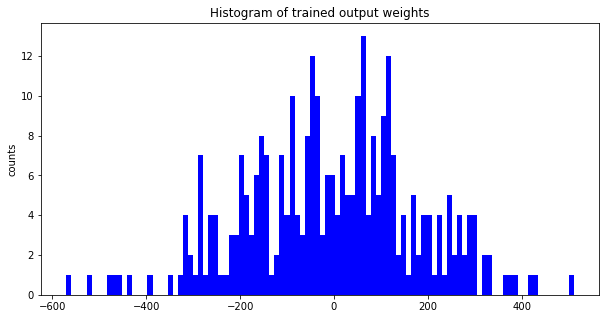


shape of val input (samples, timesteps, features):  (217, 89, 180)
shape of train input (samples, timesteps, features):  (866, 89, 180)

shape of model predictions on validation input (samples, 1):  (217, 1)
shape of val targets (samples, 1):  (217, 1)

train_mae:  0.1454
val_mae:  0.3032

train_mse:  0.035
val_mse:  0.1443


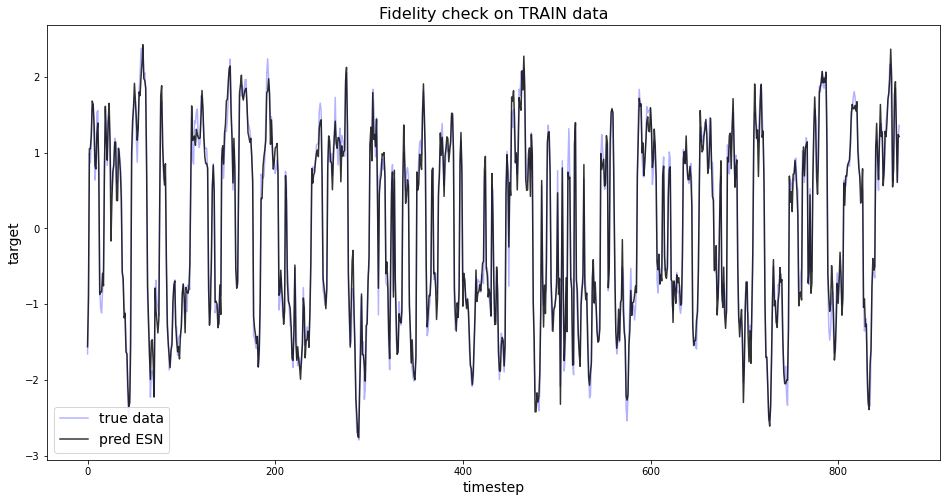

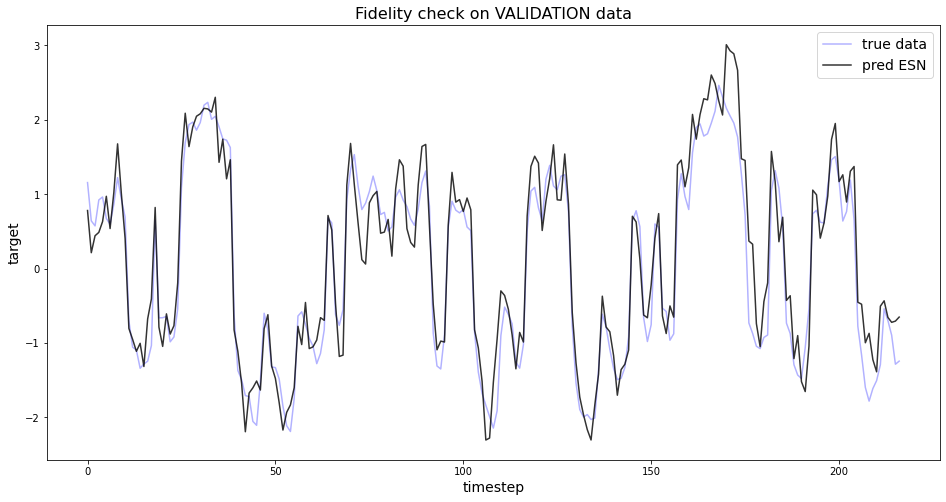

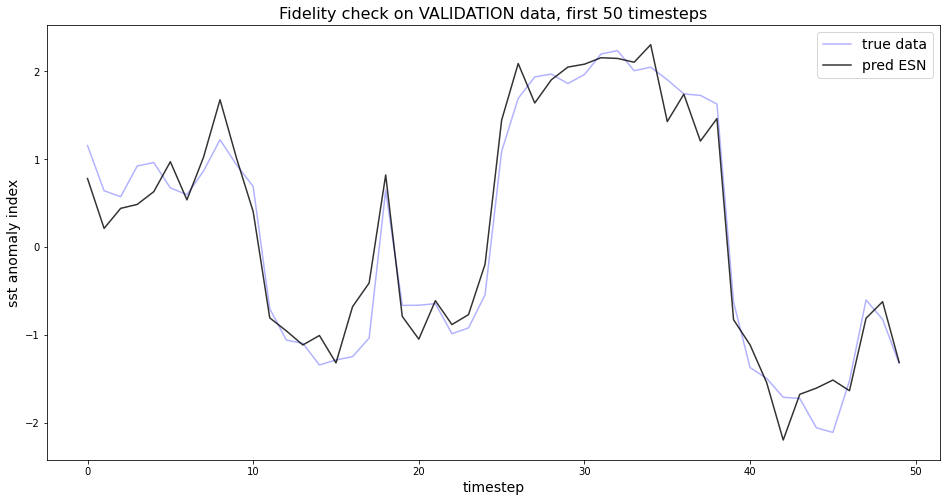

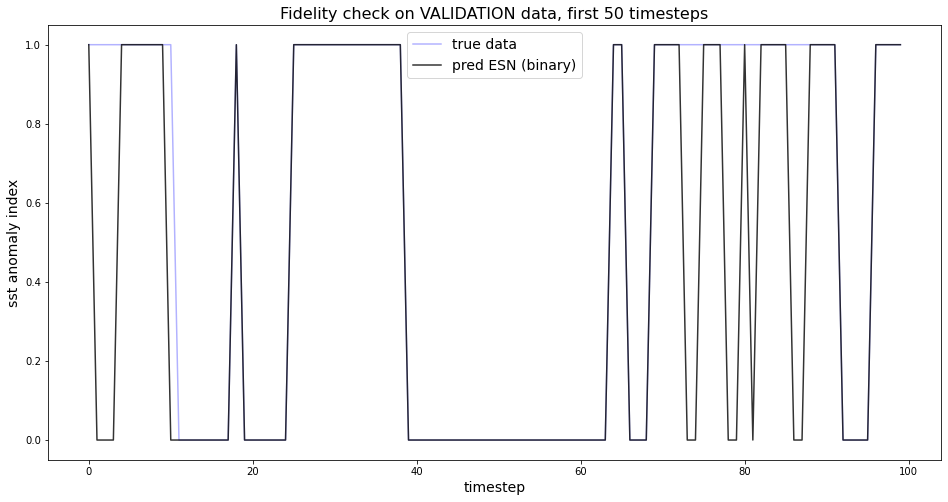


Validation accuracy:
El Nino:  0.86
La Nina:  1.0

Train accuracy:
El Nino:  0.91
La Nina:  1.0


In [51]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL timesteps for all inputs).
model, model_short, all_states = setESN(input_length=input_length, n_features=n_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input, train_target, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                       train_target, val_target,
                                                                       verbose=verbose)

if verbose:   
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 50 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target[:50])),val_target[:50],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:50])),val_pred[:50],'k',  alpha=0.8, label='pred ESN')
    plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()

# Convert to binary prediction:
train_pred_bin = (train_pred > 0.5)
val_pred_bin = (val_pred > 0.5)

if verbose:
    # Fidelity check for binary prediction and target.
    # Plot val_pred_bin vs. val_targets, but only the first 50 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_bin[:100])),val_target_bin[:100],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:100])),val_pred_bin[:100],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()

## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin == val_target_bin) & (val_target_bin == 1)) / sum(val_target_bin == 1)
val_acc_LaNina = sum((val_pred_bin == val_target_bin) & (val_target_bin == 0)) / sum(val_target_bin == 0)

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin == train_target_bin) & (train_target_bin == 1)) / sum(train_target_bin == 1)
train_acc_LaNina = sum((train_pred_bin == train_target_bin) & (train_target_bin == 0)) / sum(train_target_bin == 0)

if verbose:
    print("\nValidation accuracy:")
    print("El Nino: ", np.round(val_acc_ElNino[0],2))
    print("La Nina: ", np.round(val_acc_LaNina[0],2))

    print("\nTrain accuracy:")
    print("El Nino: ", np.round(train_acc_ElNino[0],2))
    print("La Nina: ", np.round(train_acc_LaNina[0],2))



### Layer-wise Relevance Propagation with baseESN on ENSO

**First approach**: Since input values are unbounded (when scaled to [-1,1]), use the following rule for translating the relevance from layer $j$ to previous layer $i$:

$$R_i = \sum_j \frac{w_{ij}^2}{\sum_i w_{ij}^2}R_j$$

In this approach all bias terms are neglected and we don't take states $a_i$ into account. We find some structure in relevance map but not as expected. Note: Need small leak rate $\alpha$, to have enough relevance backpropagating through reccurent reservoir timesteps!

**Second approach**: Use the following propagation rule to pass information backward from layer $j$ to previous layer $i$:

$$R_i = \sum_j \frac{z_{ij}^+}{\sum_i z_{ij}^+}R_j$$

Here we only take positive contributions of pre-activations $z_{ij}^+ = (a_i w_{ij})^+$ into account. Find some more reasonable structure in relevance map, but **not highlighting Nino region**, as expected.

**Third approach**: Slightly adjusted from second approach, now take BOTH, positive and negative contributions of pre-potential into account. This doesn't work.

#### Side experiments:

* Using **second approach** for *ALL* El Nino samples and then averaging over all resulting relevance maps: Still find **no highlighted Nno region** in mean relevance map.
* Tried to work with zero input and reservoir weights (**ESN_functions_v04_nobias.py**), didn't see any major effect.

#### Outlook

* Could try to reduce input samples to some **extended Pacific region**, as done for LRP with MLP. Didn't work there. But could help for LRP with baseESN, since we then have **less timesteps** and hence less layers in un-folded reservoir transitions.
* Then try different approach: Couple each input samples gridpoint to one reservoir unit, hence having a matrix of input weights with zeros expect for the main diagonal, filled with ones. Feed input only in first timestep. Let reservoir swing for some timesteps, without additional inputs.
 * Does that work for image classification? How does accuracy depend on number of swing steps?
 * If yes, try LRP: Get relevance map for whole sample, not row-wise, as before.
* Or consult [Montavon, 2017] paper, mentioned in [Toms et al., 2020]: Do they have other propagation rules?
* Also could try to feed sst anomaly fields **column-wise** to baseESN, but don't expect any improvement.
* Or check **misclassified El Nino samples**: 
 * Is it always the same 6-7% of samples for various model initializations? 
 * Is the prediction just slightly off the target, hence classified as *neutral*?
 * What do these samples have in common, that deceives the model prediction?

**Note:** So far we haven't calculated relevance for the last timestep (t=1)...

Sample dimensions and prediction:
raw sample shape (1, timesteps, features):  (1, 89, 180)
number of timesteps:  89
number of input features in_feat:  180
number of res. units n_res:  300
leak rate alpha:  0.03
model prediction on sample:  1.637
true target for sample:  1.638

Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (180, 300)
input biases b_in (res. units):  (300,)
reservoir weights W_res (res. units, res. units):  (300, 300)
reservoir biases b_res (res. units):  (300,)
output weights W_out (res. units, output features):  (300, 1)
output biases b_out (output features):  (1,)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1449/2530447569.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



Tensor shapes:
input tensor U (timesteps, input features):  (89, 180)
all res. states X (timesteps, res. units):  (89, 300)
activations ACT (timesteps, res. units):  (89, 300)


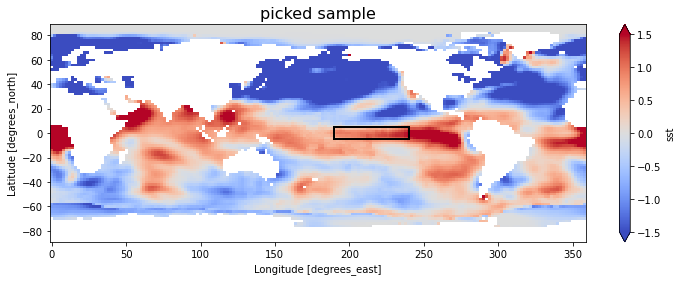

In [52]:
### Pick out ONE El Nino sample to be analysed:
sample_id = 6
sample = train_input[sample_id:sample_id+1,:]

# Plot sample input
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_fields_NinoNina[sample_id].name = 'sst anomaly deg Celsius'
sst_anomaly_fields_NinoNina[sample_id].plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('picked sample', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = sample.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = sample.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

# Have trained model as pre-requisite. Check prediction and target on picked sample:
pred = model.predict(sample)[0,0]
target = train_target[sample_id,0]

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, timesteps, features): ", sample.shape)
print("number of timesteps: ", timesteps)
print("number of input features in_feat: ", in_feat)
print("number of res. units n_res: ", n_res)
print("leak rate alpha: ", a)
print("model prediction on sample: ", np.round(pred,3))
print("true target for sample: ", np.round(target,3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
print("reservoir biases b_res (res. units): ", b_res.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Set tensors for inputs U, activation layer ACT and all reservoir states X:

# Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:,:]

# Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
X = all_states.predict(sample)[0,:,:]

# Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

# Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
ACT = (X - (1 - a) * X_prime) / a

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (timesteps, input features): ", U.shape)
print("all res. states X (timesteps, res. units): ", X.shape)
print("activations ACT (timesteps, res. units): ", ACT.shape)

In [53]:
### LRP on baseESN: First attempt, use only squared weights for propagation rule.

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to single OUTPUT unit x_o:
R_i = (a * (W_out**2) / sum(W_out**2) * pred)[:,0]
R_j_1 = ((1 - a) * (W_out**2) / sum(W_out**2) * pred)[:,0]

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((W_in**2) / (np.sum(W_in**2, axis=0) + np.sum(W_res**2, axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((W_res**2) / (np.sum(W_in**2, axis=0) + np.sum(W_res**2, axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

In [54]:
### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(t) connecting to x_i units of ACT(t).
    R_k = np.sum((W_in**2) / (np.sum(W_in**2, axis=0) + np.sum(W_res**2, axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(t-1) connecting to x_i units of ACT(t).
    R_j_2 = np.sum((W_res**2) / (np.sum(W_in**2, axis=0) + np.sum(W_res**2, axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

In [39]:
pred

1.5253906

In [40]:
print(pred - R_i_sum[0] - R_j_1_sum[0])
print(R_i_sum[0] - R_k_sum[0] - R_j_2_sum[0])

-4.2292821533784775e-07
-5.467943042791745e-10


In [41]:
for i in np.arange(0,T-1):
    print("\n",R_j_sum[i] - R_i_sum[i+1] - R_j_1_sum[i+1])
    print(R_i_sum[i+1] - R_k_sum[i+1] - R_j_2_sum[i+1])
    print(R_k_sum[i] + R_j_1_sum[i] + R_j_2_sum[i])


 -4.343587534094695e-08
-2.7989699447061867e-10
1.5253910484750097

 -4.060098035552073e-08
-4.2450665205251426e-10
1.5047011039332574

 -3.8211965147638693e-08
-4.5429260353557765e-10
1.4842960537243926

 -3.618788468884304e-08
-2.7557689463719726e-10
1.4641718531365768

 -3.774539436562918e-08
-3.005879989359528e-10
1.444324502368545

 -3.6631263355957344e-08
-3.3242031349800527e-10
1.424750080324884

 -4.2668034438975155e-08
-3.8198777474462986e-10
1.4054447081598482

 -3.7036443245597184e-08
-3.474269760772586e-10
1.3864045702266594

 -3.3462129067629576e-08
-1.6552803572267294e-10
1.3676258988998597

 -3.7543031794484705e-08
-2.937667886726558e-10
1.349105007464459

 -3.9335645851679146e-08
-2.892193151637912e-10
1.3308382497943967

 -3.0915543902665377e-08
-3.001332515850663e-10
1.3128220264188712

 -3.5235643736086786e-08
-1.6370904631912708e-10
1.2950528018864134

 -3.819332050625235e-08
-1.7644197214394808e-10
1.277527109874427

 -3.602872311603278e-08
-2.455635694786906e-10


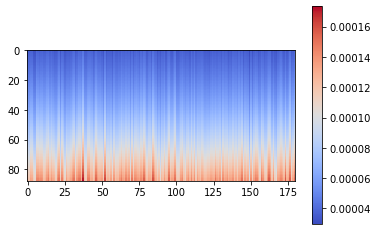

In [55]:
plt.imshow(R_all, cmap='coolwarm', interpolation='nearest')#, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

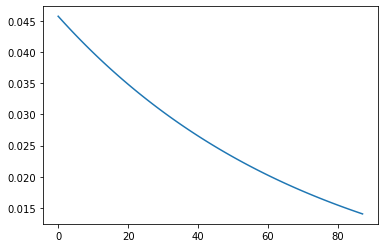

In [43]:
plt.plot(R_i_sum)

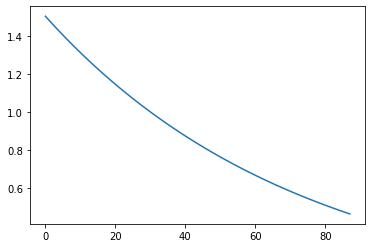

In [44]:
plt.plot(R_j_sum)

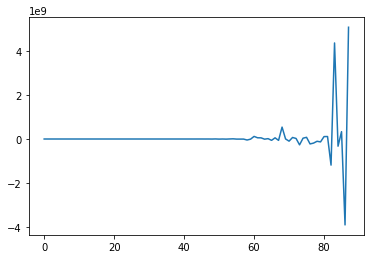

In [28]:
plt.plot(R_k_sum)

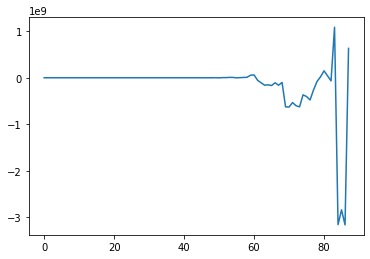

In [29]:
plt.plot(R_j_1_sum)

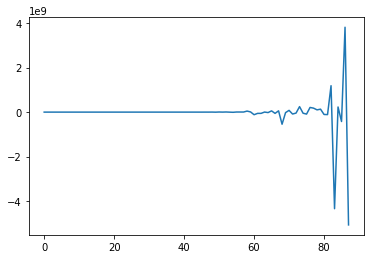

In [30]:
plt.plot(R_j_2_sum)

In [56]:
### LRP on baseESN: Second attempt, only take positive contributions of pre-potential into account.

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to single OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
       sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
         / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

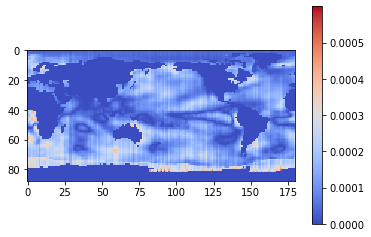

In [57]:
plt.imshow(R_all, cmap='coolwarm', interpolation='nearest')#, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

In [58]:
### LRP on baseESN: Third attempt slightly adjusted from second attempt, 
###                 take BOTH, positive and negative contributions of pre-potential into account.

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to single OUTPUT unit x_o:
R_i = (a * np.multiply(ACT[T,:],W_out[:,0]) /
       sum(np.multiply(ACT[T,:],W_out[:,0])) * pred)
R_j_1 = ((1 - a) * np.multiply(ACT[T,:],W_out[:,0])
         / sum(np.multiply(ACT[T,:],W_out[:,0])) * pred)

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum(np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum(np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum(np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum(np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum(np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum(np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum(np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum(np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum(np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum(np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum(np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

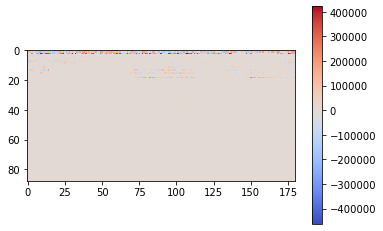

In [59]:
plt.imshow(R_all, cmap='coolwarm', interpolation='nearest')#, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

In [76]:
### LRP with baseESN on ALL El Nino / La Nina samples (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_ElNino = train_input[(train_target_bin==1)[:,0]]
samples_LaNina = train_input[(train_target_bin==0)[:,0]]

## Split targets accordingly:
targets_ElNino = train_target[(train_target_bin==1)[:,0]]

if verbose:
    print("samples_ElNino shape: ", samples_ElNino.shape)
    print("samples_LaNina shape: ", samples_LaNina.shape)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = samples_ElNino.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = samples_ElNino.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

if verbose:
    ## Check dimensions:
    print("\nModel weights and biases, Dimensions:")
    print("=====================================")
    print("input weights W_in (input features, res. units): ", W_in.shape)
    print("input biases b_in (res. units): ", b_in.shape)
    print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
    print("reservoir biases b_res (res. units): ", b_res.shape)
    print("output weights W_out (res. units, output features): ", W_out.shape)
    print("output biases b_out (output features): ", b_out.shape)

## Initialize storage for mean relevance over all ElNino samples.
## Note: First timestep is still missing in algorithm.
R_all_mean = np.zeros((T, in_feat))
    
#Loop over El Nino samples:
for sample_id in range(len(samples_ElNino)):
    
    # Get current sample:
    sample = samples_ElNino[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)[0,0]
    target = targets_ElNino[sample_id,0]
    
    if verbose:
        ## Check dimensions and prediction:
        print("Sample dimensions and prediction:")
        print("=================================")
        print("raw sample shape (1, timesteps, features): ", sample.shape)
        print("number of timesteps: ", timesteps)
        print("number of input features in_feat: ", in_feat)
        print("number of res. units n_res: ", n_res)
        print("leak rate alpha: ", a)
        print("model prediction on sample: ", np.round(pred,3))
        print("true target for sample: ", np.round(target,3))



    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    if verbose:
        # Check dimensions:
        print("\nTensor shapes:")
        print("==============")
        print("input tensor U (timesteps, input features): ", U.shape)
        print("all res. states X (timesteps, res. units): ", X.shape)
        print("activations ACT (timesteps, res. units): ", ACT.shape)
        
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to single OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
           sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
             / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.reshape(R_k,(1,len(R_k)))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.


    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_all

## Get mean relevance over ALL samples:
R_all_mean = R_all_mean / len(samples_ElNino)

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1256/3087621169.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


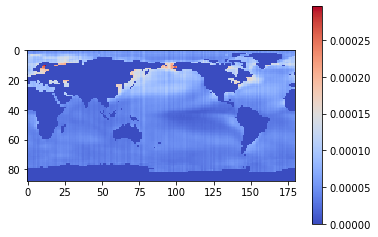

In [78]:
plt.imshow(R_all_mean, cmap='coolwarm', interpolation='nearest')#, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()